# MA934  Numerical Methods - Workbook 2

In [1]:
using PyPlot
# default markersize
ms = 4
using Distributions
include("modules/KVPair.jl")
include("modules/LList.jl")
include("modules/FTree.jl")

buildFTree (generic function with 1 method)

## Question 1: Linear search using a linked list

The file KVPair.jl defines a simple data structure to represent an (Int64, Float64) key-value pair. 

The file LList.jl defines a linked list that stores a KVPair at each node. Many languages have a keyword NULL. A pointer to any object can take the value NULL to indicate that it doesn't point to anything. NULL is often used to denote the end of a list, the leaves of a tree etc. Julia does not support NULL pointers. This causes a difficulty in implementing recursive data structures. Instead Julia provides a parametric data type Nullable{T} to represent missing values. It is possible to use Nullable types to define recursive data structures although some of the resulting definitions are a bit clumsy. I'm not sure that this is the canonical way to implement structural recursion in Julia. 

The following points are important:

* if a variable has type Nullable{T} then it can either contain a value of type T or nothing (ie a missing value). 
* the function isnull(x) checks whether a nullable type x has a value or not. 
* the function get(x) returns the actual value (of type T) contained in a nullable type x.

Much more information can be found at https://docs.julialang.org/en/stable/manual/types/

The function 

> buildLList(dataArray::Array{KVPair, 1})

takes an array of KVPair objects as input and returns an LList containing these KVPairs. This is illustrated in the code below.

1. Write a recursive function that traverses the list and prints out the key-value pairs stored in it. Check that your function works.
2. Write a function search(list::Nullable{LList}, k::Int64) that searches an LList for the key k and returns the corresponding KVPair if it is present and a Nullable{KVPair} otherwise. Verify that your function works.
3. Use Julia's @timed macro to measure how the typical computational cost of your search() function grows with the length of the list. 

In [2]:
include("modules/search.jl")

FTintervalmembership (generic function with 1 method)

The file above contains methods for printing an LList object and searching for a given key value, and solving the interval membership problem with linear and Fenwick tree search. The signatures are.

Prints the values of the KVPairs in an LList object.

print_LList(L::Nullable{LList})

Searches the LList for the KVPair with key value S and returns the
KVPair, if no such KVPair exists an Nullable{KVPair} is returned.

search_LList(L::Nullable{LList}, S::Int64)

For KVPairs each containing the partial sums of the generated intervals this function searches for the KVPair corresponding to the interval in which x lies. 

intervalmembership(L::Nullable{LList}, x::Float64)

Completes the same operation as above but using a Fenwick tree.

FTintervalmembership(FT::Nullable{FTree},x::Float64)

## Checking the print and key-search functions.

Below a LList, of size 10, is constructed out of a simple list of integers and printed.

In [3]:
X = [1,2,3,4,5,6,7,8,9,10]

# build the KVPairs
A = Array{KVPair,1}(length(X))
for i in 1:length(X)
    A[i] = KVPair(i,X[i])
end

L = buildLList(A)

# print the LList like this
print_LList(L)

KVPair(1, 1.0)
KVPair(2, 2.0)
KVPair(3, 3.0)
KVPair(4, 4.0)
KVPair(5, 5.0)
KVPair(6, 6.0)
KVPair(7, 7.0)
KVPair(8, 8.0)
KVPair(9, 9.0)
KVPair(10, 10.0)


Now the search function is used to find an existing and non-existing key, using the same LList.

In [4]:
# find existing key
println(search_LList(L,7))
#find non-existing key
println(search_LList(L,25))

KVPair(7, 7.0)
Nullable{KVPair}


## Computational Complexity

below the completion time for the search_LList function is tested using LLists with power of 2 lengths from $2^{0}$ to $2^{15}$. The search was performed for the mid key value.

In [5]:
l=15
N=zeros(l)
for k in 1:l
    N[k] = convert(Int64,2^k)
end

T = []

for s in N
    s = convert(Int64,s)
    A = Array{KVPair,1}(s)
    for i in 1:s
        A[i] = KVPair(i,i)
    end

    L = buildLList(A)
    # search for the middle key value
    t = @timed search_LList(L,convert(Int64,s/2))
    println(t[1])
    append!(T,t[2])
end

KVPair(1, 1.0)
KVPair(2, 2.0)
KVPair(4, 4.0)
KVPair(8, 8.0)
KVPair(16, 16.0)
KVPair(32, 32.0)
KVPair(64, 64.0)
KVPair(128, 128.0)
KVPair(256, 256.0)
KVPair(512, 512.0)
KVPair(1024, 1024.0)
KVPair(2048, 2048.0)
KVPair(4096, 4096.0)
KVPair(8192, 8192.0)
KVPair(16384, 16384.0)


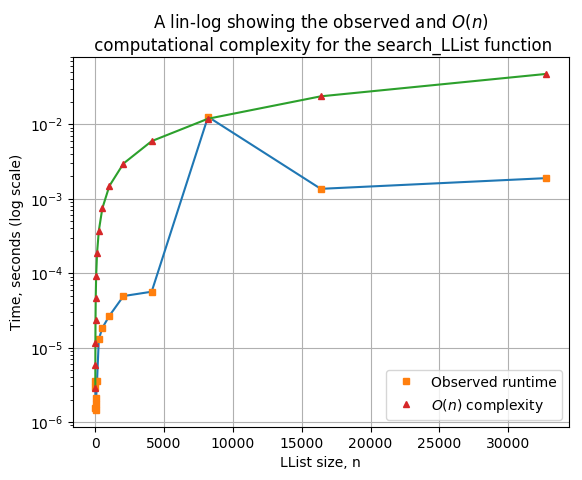

PyObject <matplotlib.legend.Legend object at 0x129c45590>

In [6]:
# the plotting
semilogy(N,T)
semilogy(N,T, label="Observed runtime", "s", markersize=ms)
f = minimum(T)
semilogy(N,f.*N)
semilogy(N,f.*N, label=L"O(n)"" complexity", "^", markersize=ms)
title("A lin-log showing the observed and "L"O(n)""\n computational complexity for the search_LList function")

xlabel("LList size, n")
ylabel("Time, seconds (log scale)")

grid()
legend()


<font color=blue>
This is presumably roughly linear scaling? This would be much clearer on a log-log plot...
</font>

<font color=blue>
Excellent answer: 14/15
</font>

## Question 2: Interval membership

The problem of interval membership is the following: given a set of contiguous intervals, 

$\left\{[x_0, x_1), [x_1, x_2), \ldots, [x_{n-2}, x_{n-1}), [x_{n-1}, x_n)\right\}$

spanning the interval $[x_1, x_n)$ and given a random number $x \in [x_1, x_n)$, determine the interval in which $x$ lies. The standard numerical algorithm for stochastic simulation of continuous-time Markov processes (eg birth-death process, contact process, SIR model etc) requires solving an interval membership problem at each time step. It is therefore important to be able to solve it efficiently. Note, we cannot assume that all intervals are the same length.

We can solve the interval membership problem with $n$ interval by a variant of linear search in $O(n)$ time. We will demonstrate below that it can be solved in $O(\log\, n)$ time using a variant of a data structure known as a Fenwick tree.

**1)** Use Julia's random number generator to generate $n$ random interval lengths, $y_1, y_2, \ldots, y_n$ between 0 and 1 as shown: 

The corresponding interval membership problem is constructed from the partial sums:
$$x_i = \sum_{j=1}^i y_j, \ \ \ \ \ i=1,2,\ldots n.$$ 
Using the objects defined in KVPair.jl and LList.jl, create an array of key-value pairs, $(i, x_i)$, associating each interval with the corresponding partial sum and store this array in a linked list. Print the list for a small value of $n$to verify that it works.

**2)** Modify the search function you wrote above to write a recursive function

$$\text{intervalmembership(list::Nullable{LList}, x::Float64)}$$

that takes the LList containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to measure how the typical computational cost grows with $n$. 

**3)** The file FTree.jl defines a data structure implementing a variant of a Fenwick tree that can solve the interval membership problem as described in the lectures/notes. The function 

$$\text{buildFTree(T::Nullable{FTree}, dataArray::Array{KVPair, 1})}$$

takes the array of KVPairs containing the interval lengths as input, recursively constructs the tree and returns the FTree containing the correct key-value pairs (note a key of -1 is assigned to all non-leaf nodes).

Write a recursive function

$$\text{intervalmembership(FT::Nullable{FTree}, x::Float64)}$$

that takes the FTree containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as 
inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to compare how the typical computational compares to the above linear search version. Note it can sometimes be difficult to directly measure $O(\log\, n)$ growth in computation time since the problem size needs to become very large to register appreciable run times.

## Generating the LList with partial sums.

In [7]:
# Set number of intervals
n=10
# Seed for random number generator. 
# You should choose your own seed so that everyone does not end up with the same random sequences
seed = 1235 
# Initialise the random number generator
rng = MersenneTwister(seed)
# Generate a sample of n uniform random numbers in the interval [0,1]
Y = rand(rng, n);
X = zeros(n)

# store the partial sums in X
for i in 1:length(Y)
    X[i] = sum(Y[1:i])
end

# create the KVPairs with the partial sums
A = Array{KVPair,1}(n)
for i in 1:n
    A[i] = KVPair(i,X[i])
end

# build the LList and print it to check
L = buildLList(A)
print_LList(L)

KVPair(1, 0.09515880533766441)
KVPair(2, 0.3660566209216942)
KVPair(3, 1.2723720624303905)
KVPair(4, 2.1059565816183605)
KVPair(5, 3.0510113282306257)
KVPair(6, 3.494680246826905)
KVPair(7, 4.3992572660623805)
KVPair(8, 5.340855742136259)
KVPair(9, 5.378445491782055)
KVPair(10, 6.374527549662986)


## Verifying the linear interval membership search 

Using the same LList as above, the KVPair.value entries give the 
end of each interval, so searching for $x=3.6$ should give interval 7.

In [8]:
n=10
xₙ = search_LList(L,n)
x = rand(collect(0:0.001:xₙ.value),1)[1]
x = 3.6
i = intervalmembership(L,x).key
print_LList(L)
println("Number ", x," is in interval ", i)

KVPair(1, 0.09515880533766441)
KVPair(2, 0.3660566209216942)
KVPair(3, 1.2723720624303905)
KVPair(4, 2.1059565816183605)
KVPair(5, 3.0510113282306257)
KVPair(6, 3.494680246826905)
KVPair(7, 4.3992572660623805)
KVPair(8, 5.340855742136259)
KVPair(9, 5.378445491782055)
KVPair(10, 6.374527549662986)
Number 3.6 is in interval 7


## Computational complexity (linear search)
Now multiple LLists are constructed with size as powers of 2 and a search perfomed for a middle KVPair.value entry.

In [9]:
# max power of 2
l=15
N=zeros(l)
for k in 1:l
    N[k] = convert(Int64,2^k)
end

T = []

rng = MersenneTwister(seed)

for s in N
    s = convert(Int64,s)
    seed = 1235 
    Y = ones(s)
    X = zeros(s)
        
    for i in 1:length(Y)
        X[i] = sum(Y[1:i])
    end

    A = Array{KVPair,1}(s)
    for i in 1:s
        A[i] = KVPair(i,X[i])
    end

    L = buildLList(A)
    # search for a value in the middle
    t = @timed intervalmembership(L,s/2)
    println(t[1])
    append!(T,t[2])
end

KVPair(2, 2.0)
KVPair(3, 3.0)
KVPair(5, 5.0)
KVPair(9, 9.0)
KVPair(17, 17.0)
KVPair(33, 33.0)
KVPair(65, 65.0)
KVPair(129, 129.0)
KVPair(257, 257.0)
KVPair(513, 513.0)
KVPair(1025, 1025.0)
KVPair(2049, 2049.0)
KVPair(4097, 4097.0)
KVPair(8193, 8193.0)
KVPair(16385, 16385.0)


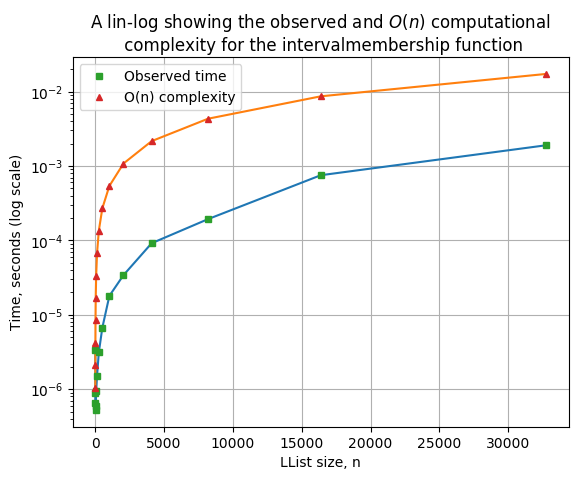

PyObject <matplotlib.legend.Legend object at 0x132ac0050>

In [10]:
k = minimum(T)
semilogy(N,T)
semilogy(N,k.*N)
semilogy(N,T, label="Observed time", "s", markersize=ms)
semilogy(N,k.*N, label="O(n) complexity", "^", markersize=ms)

title("A lin-log showing the observed and "L"O(n)"" computational \n complexity for the intervalmembership function")

xlabel("LList size, n")
ylabel("Time, seconds (log scale)")

grid()
legend()


<font color=blue>
Same here!
</font>

## Verifying the Fenwick tree interval membership function

Here the intervals are all length 1 and so value $3.6$ should be found in the 3rd interval, that is in the interval $[3,4)$.

In [11]:
seed = 1235 
rng = MersenneTwister(seed)
Y = [1,2,3,4,5,6,7,8,9,10]

# construct the Fenwick tree KVPairs (constructer does the partial sums)
FTvalues= Array{KVPair}(length(Y))
for i in 1:length(Y)
    FTvalues[i] = KVPair(i,Y[i])
end

# construct the Fenwick tree
T = Nullable{FTree}(FTree(KVPair(0,0.0)))
T=buildFTree(T,FTvalues);

x=3.6

l = FTintervalmembership(T,x)
println(x, " is in interval ", l.key)

3.6 is in interval 3


## Computational complexity (Fenwick tree)

In [18]:
# max power of 2
l=15
N=zeros(l)
for k in 1:l
    N[k] = convert(Int64,2^k)
end

times = []

for s in N
    s = convert(Int64,s)
    seed = 1235 
    Y = ones(s)
    X = zeros(s)

    FTvalues= Array{KVPair}(s)
    for i in 1:s
        FTvalues[i] = KVPair(i,Y[i])
    end

    T = Nullable{FTree}(FTree(KVPair(0,0.0)))
    T=buildFTree(T,FTvalues);
    # find interval for value in middle
    t = @timed FTintervalmembership(T,s/2)
    append!(times,t[2])
end

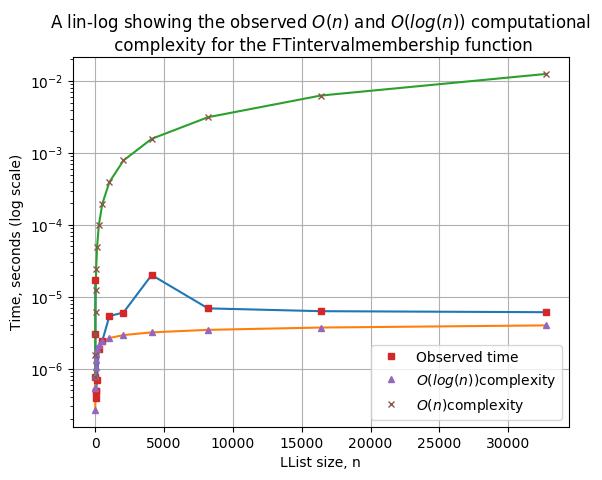

PyObject <matplotlib.legend.Legend object at 0x1480ed150>

In [19]:
k = minimum(times)
semilogy(N,times)
semilogy(N,k.*log.(N))
semilogy(N,k.*N)
semilogy(N,times, label="Observed time", "s", markersize=ms)
semilogy(N,k.*log.(N), label=L"O(log(n))""complexity", "^", markersize=ms)
semilogy(N,k.*N, label=L"O(n)""complexity", "x", markersize=ms)

title("A lin-log showing the observed "L"O(n)"" and "L"O(log(n))"" computational \n complexity for the FTintervalmembership function")

xlabel("LList size, n")
ylabel("Time, seconds (log scale)")

grid()
legend()


<font color=blue>
Excellent answer: 14/15
</font>

## Question 3: Gillespie algorithm for heterogeneous diffusion

The Gillespie algorithm is a dynamic Monte Carlo algorithm that generates statistically correct realisations of a continous time Markov process. See https://en.wikipedia.org/wiki/Gillespie_algorithm It is used heavily in stochastic simulation of chemical and biological reaction networks and population dynamics. In this question we use it to simulate one-dimensional diffusion of heterogeneous particles whose diffusion constants are independently drawn from an exponential distribution.

The basic idea of the algorithm is as follows
1. Create a list $\left\{(i, r_i), i=1,\ldots M\right\}$,  of all possible transitions (events), $i$, that can occur in the system and the corresponding transition rates, $r_i$.
2. Calculate the total rate
$$R = \sum_{i=1}^M r_i$$
and divide the interval $[0, R]$ into $M$ intervals whose lengths are given by the $r_i$.
3. Generate a uniform random number in the range $[0,R]$ and determine which interval it falls in. 
4. Perform the corresponding transition and update the time variable by an amount $\Delta t = 1/R$.
5. Repeat until the desired simulation time is reached.

To be concrete, suppose with have $N$ particles on the interval $[-L, L]$ initially located at $x=0$. Each particle can hop a distance $\Delta x$ to the left or to the right with equal probability. The rate of hopping is initially considered to be the same for all particles:

$$ r_i = \frac{D}{2}\,\frac{1}{(\Delta x)^2} $$

This choice ensures that in the continous limit ($\Delta x \to 0$, $N\to \infty$), the density of particles $c(x,t)$ on the line will satisfy the usual diffusion equation with diffusion coefficient $D$ (recall MA933):

$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$

with initial condition $c(x,0) = \delta(x)$.

The steps of the algorithm then correspond to the following:
1. There are $M= 2 N$ possible transitions at each step: each of $N$ particles can hop a distance $\Delta x$ either left or right with the above rates. We index them as follows: events k=1:N correspond to particle k hopping to the right, events k=N+1:2N correspond to particle k-N hopping to the left.
2. The total rate is 
$$ R = \frac{D N}{(\Delta x)^2}.$$
3. Generate a uniform random number in the range $[0,R]$ and determine the index $k$ of particle to move and the direction.
4. Update the position of particle $k$ accordingly.
5. Repeat.

The following piece of code implements the Gillespie algorithm for N=100, L=10, $\Delta x = 0.1$ and $D=1$, converts the particle positions to particle density and compares to the solution of the diffusion equation on an unbounded domain at t=1 (we assume that L=10 is far enough from zero to be considered unbounded):

$$c(x, t) = \frac{1}{\sqrt{2 \pi D t}}\, \exp [-\frac{1}{2}\frac{x^2}{D t} ]$$

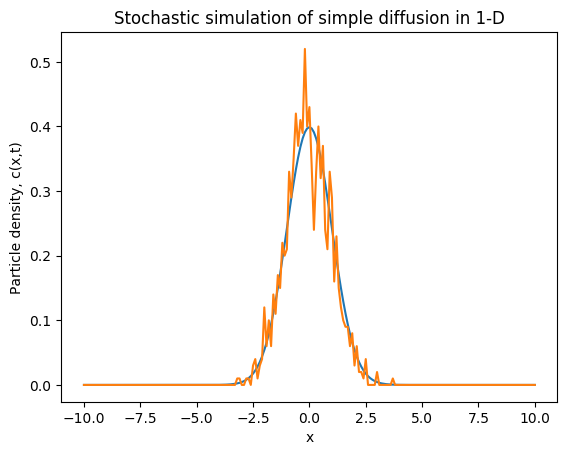

PyObject <matplotlib.text.Text object at 0x12984d190>

In [14]:
L=10.0
N=1000
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1.0
t=0.0


r = (D/2.0)/(dx*dx)
totalRate = 2.0*N*r
dt = 1.0/totalRate
T=1.0

# This is the main loop
while t < T
    # Pick an event
    k = rand(1:2*N)
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot(X, P, label="Numerical estimate of particle density")
xlabel("x")
ylabel("Particle density, c(x,t)")
title("Stochastic simulation of simple diffusion in 1-D")

**1)** The code above makes critical use of the fact that all intervals have the same width in order to decide which particle to move at each step. Suppose now that instead of being equal to $D$ for each particle, the diffusion coefficients are drawn from an exponential distribution with mean $D$:

$$ P(x) = \frac{1}{D} \exp\left(-\frac{x}{D}\right). $$

Modify the code to account for this, using your code from Q2 above to solve the interval membership problem using linear search. You will need to use Julia's randexp() function to generate values for the diffusion coefficients. What is the largest value of $N$ you can simulate in a "reasonable" time?

**2)** Try again using your Fenwick tree from Q2 to solve the interval membership problem and compare. What is the largest value of $N$ you can simulate now?

**3)** Show analytically that the solution of the heterogenous diffusion problem is

$$ c(x,t) = \frac{\exp \left(-\sqrt{\frac{2}{D\,t}}\, |x| \right)}{\sqrt{2\, D\, t}}$$

You will probably need the integral formula (Formula 3.325 of Gradshteyn and Rizhik, 7th Ed.)

$$ \int_0^\infty \exp\left(-a\,x^2 - \frac{b}{x^2} \right)\, dx =  \frac{1}{2}\,\sqrt{\frac{\pi}{a}}\,\exp\left(-2 \sqrt{a\,b} \right).$$
Use this formula to validate your numerical results.



## Gillespie algorithm using linear search

Below the diffusion, with random diffusion coefficients, is simulated stochastically using linear search and using
Fenwick tree search to solve the interval membership problem.

One run gave runtimes of $210.24$ seconds for $10000$ particles with linear search. But using Fenwick tree search a simulation of $1000000$ particles completed in $45.73$ seconds, so a lot faster!

Loop Completion time: 191

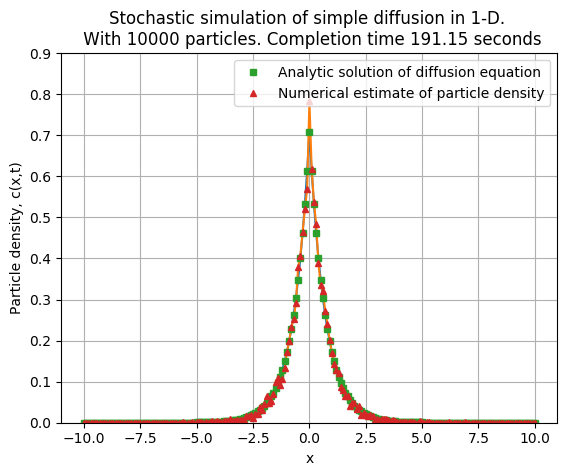

In [15]:
L=10.0
N=10000
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D=1.0
t=0.0
T=1.0

# generate the random diffusion coefficients
DC = rand(Exponential(D),N)

TotalRate = sum(DC)*(1/(2*dx*dx))

XX = zeros(N)
# find the partial sums 
for i in 1:length(Y)
    XX[i] = sum(DC[1:i])*(1/(2*dx*dx))
end

# create the KVPairs with the partial sums and construct the LList
A = Array{KVPair,1}(N)
for i in 1:N
    A[i] = KVPair(i,XX[i])
end
L = buildLList(A)

dt = 1.0/(2*TotalRate)

time = @timed while t < T
    # 2*TotalRate to decide if forward or backward hop
    x = rand(0:2*TotalRate)
    
    # implement the linear interval membership search
    if x <= TotalRate 
        particleId = intervalmembership(L,x).key
        hop=1
    else
        particleId = intervalmembership(L,x-TotalRate).key
        hop=-1
    end

    # record the hop
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare, now with new function
function normal2(x, D, t)
    return (1.0./sqrt.(2.0.*D.*t)).*exp.(-sqrt.(2/(D*t)).*abs.(x))
end
P1 = normal2.(X, D, T)
plot(X, P1)
plot(X, P)
plot(X, P1, label="Analytic solution of diffusion equation", "s", markersize=ms)
plot(X, P, label="Numerical estimate of particle density", "^", markersize=ms)
xlabel("x")
ylabel("Particle density, c(x,t)")
t = trunc(time[2],2)
title("Stochastic simulation of simple diffusion in 1-D. \n With $N particles. Completion time $t seconds")
println("Loop Completion time: ", t)
# allow space for legend
ylim(0,0.9)
legend()
grid()

Loop completion time: 73

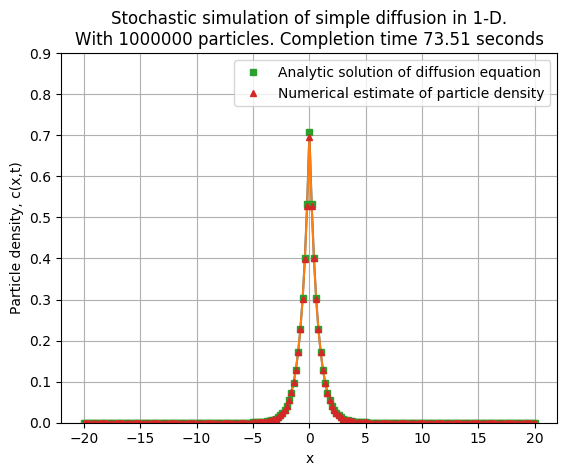

.51


In [16]:
L=20.0
N=1000000
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D=1.0
t=0.0
T=1.0
# get the random diffusion coefficients
DC = rand(Exponential(D),N)
TotalRate = sum(DC)*(1/(2*dx*dx))
XX = zeros(N)
# create KVPair values
for i in 1:length(Y)
    XX[i] = DC[i]*(1/(2*dx*dx))
end
# create KVPairs
A = Array{KVPair,1}(N)
for i in 1:N
    A[i] = KVPair(i,XX[i])
end
# build the Fenwick tree
Tree = Nullable{FTree}(FTree(KVPair(0,0.0)))
Tree  = buildFTree(Tree,A);

dt = 1.0/(2*TotalRate)

time = @timed while t < T
    x = 2*TotalRate*rand()
    # solve interval membership problem with Fenwick tree search
    if x <= TotalRate 
        particleId = FTintervalmembership(Tree,x).key
        hop=1
    else
        particleId = FTintervalmembership(Tree,x-TotalRate).key
        hop=-1
    end
    # record the hop
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:N
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end
# Calculate the theoretical density and compare, new formula
function normal2(x, D, t)
    return (1.0./sqrt.(2.0.*D.*t)).*exp.(-sqrt.(2./(D.*t)).*abs.(x))
end
P1 = normal2.(X, D, T)
plot(X, P1)
plot(X, P)
plot(X, P1, label="Analytic solution of diffusion equation", "s", markersize=ms)
plot(X, P, label="Numerical estimate of particle density", "^", markersize=ms)
xlabel("x")
ylabel("Particle density, c(x,t)")
t = trunc(time[2],2)
title("Stochastic simulation of simple diffusion in 1-D.\nWith $N particles. Completion time $t seconds")
# space for legend
ylim(0,0.9)
legend()
grid()
println("Loop completion time: ", t)

Now we have a random diffusion coefficient, $Y$, with exponential distribution and mean $D$. So to solve the heterogenous diffusion problem we take the expectation of the function

\begin{align*}
    c(x, t, Y) = \frac{1}{\sqrt{2 \pi Y t}}\, \exp \biggl(-\frac{1}{2}\frac{x^2}{Y t}\biggr)
\end{align*}

That is we solve

\begin{align*}
    \mathbb{E}_{Y}[c(x,t,Y)] = \int_{0}^{\infty} \frac{1}{D}e^{\frac{-y}{D}}\frac{1}{\sqrt{2 \pi y t}}\, \exp \biggl(-\frac{1}{2}\frac{x^2}{y t}\biggr)dy
\end{align*}

The change of variable $z^{2}=y \Rightarrow 2zdz = dy$ produces

\begin{align*}
    \mathbb{E}_{Y}[c(x,t,Y)] = \int_{0}^{\infty} \frac{1}{D}e^{\frac{-z^{2}}{D}}\frac{1}{\sqrt{2 \pi z^{2} t}}\, \exp \biggl(-\frac{1}{2}\frac{x^2}{z^{2} t}\biggr)2zdz = \frac{2}{D}\frac{1}{\sqrt{2\pi t}}\int_{0}^{\infty}e^{-\frac{z^{2}}{D}-\frac{x^{2}}{2z^{2}t}}dz
\end{align*}

Using the integral formula with $a=\frac{1}{D},b=\frac{x^{2}}{2t}$ we find the solution is

\begin{align*}
    \mathbb{E}_{Y}[c(x,t,Y)]=\frac{2}{D\sqrt{2\pi t}}\frac{1}{2}\sqrt{\pi D}e^{-2\sqrt{\frac{x^{2}}{2tD}}}
    = \frac{1}{\sqrt{2Dt}}e^{-\sqrt{\frac{2}{Dt}}|x|}
\end{align*}

Excellent answer: 15/15